In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
from statistics_results import analyze_folder
import os
import statsmodels.api as sm

In [45]:
division_stats = analyze_folder("results/division_experiment")

def extract_division_rate(filename):
    # get rate from the file name
    base = os.path.basename(filename)
    rate_str = base.replace("division_rate_", "").replace(".npz", "")
    return float(rate_str)

# function to make a dataframe for all iterations of each parameter combination
def division_stats_to_dataframe(division_stats):
    rows = []
    for filename, trials in division_stats.items():
        rate = extract_division_rate(filename)
        for trial_idx, stats in enumerate(trials):
            vols = stats["volumes"]
            deaths = stats["deaths"]
            row = {
                "division_rate": rate,
                "trial": trial_idx,
                "lowest_y": stats["lowest_y"],
                "mean_vol_type1": np.mean(vols[1]) if vols[1] else 0,
                "mean_vol_type2": np.mean(vols[2]) if vols[2] else 0,
                "deaths_type1": deaths[1],
                "deaths_type2": deaths[2],
            }
            rows.append(row)

    return pd.DataFrame(rows)

df_div = division_stats_to_dataframe(division_stats)
# Create a transformed invasion depth column
df_div["invasion_depth"] = 100 - df_div["lowest_y"]
display(df_div)

,division_rate,trial,lowest_y,mean_vol_type1,mean_vol_type2,deaths_type1,deaths_type2,invasion_depth
0,0.0004,0,85,341.132664,342.480428,0,7,15
1,0.0004,1,93,342.411855,341.613587,1,4,7
2,0.0004,2,91,342.350887,342.708991,3,2,9
3,0.0004,3,87,340.850923,342.696030,1,10,13
4,0.0004,4,87,341.796031,342.829344,4,2,13
...,...,...,...,...,...,...,...,...
145,0.0080,25,52,323.303186,342.814727,65,1,48
146,0.0080,26,21,362.944680,342.800686,62,3,79
147,0.0080,27,27,313.686124,342.866468,59,1,73
148,0.0080,28,51,358.422037,342.688054,95,3,49


P-value: 0.017151253166867542


C:\Users\benbe\AppData\Local\Temp\ipykernel_16308\3358130948.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = est2.pvalues[1]


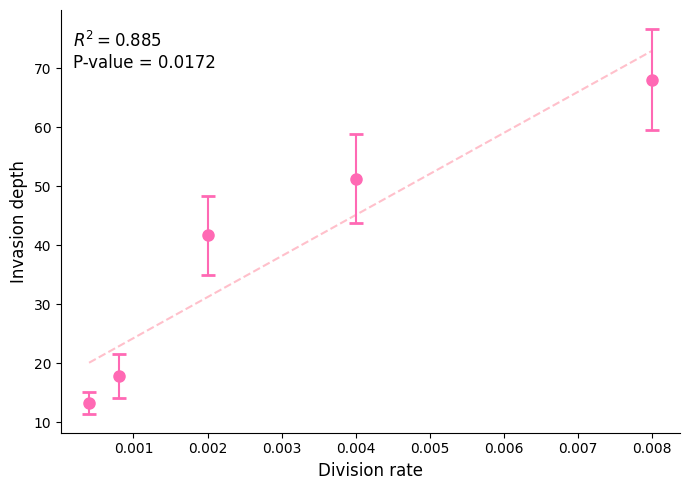

P-value: 0.9218158533550935


C:\Users\benbe\AppData\Local\Temp\ipykernel_16308\3358130948.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = est2.pvalues[1]


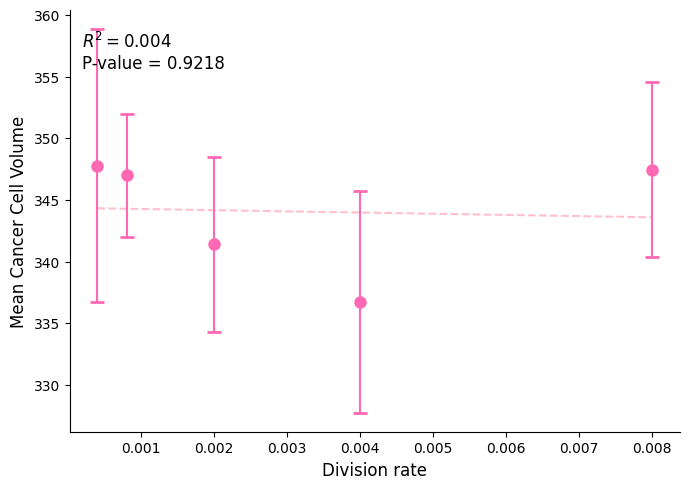

P-value: 0.01816563510986035


C:\Users\benbe\AppData\Local\Temp\ipykernel_16308\3358130948.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = est2.pvalues[1]


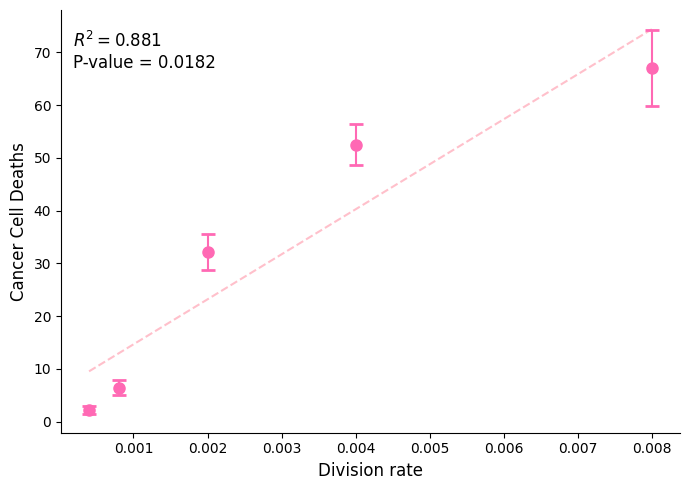

In [48]:
# linear regression on division rate and invasion depth
def perform_regression(X, y):
    X_reshaped = X.values.reshape(-1, 1)
    model = linear_model.LinearRegression()
    model.fit(X_reshaped, y)
    r2 = model.score(X_reshaped, y)

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    p = est2.pvalues[1]
    print(f"P-value: {p}")
    return model, r2, p



def plot_results(df_div, x_field, y_field, y_label):
    df_div[x_field] = pd.to_numeric(df_div[x_field])
    mean_df = (df_div.groupby(x_field, as_index=False).agg(y=(y_field, "mean")))

    model, r2, p = perform_regression(mean_df[x_field], mean_df["y"])
    plt.figure(figsize=(7,5))

    # Add mean points with error bars manually
    for rate in df_div[x_field].unique():
        subset = df_div[df_div[x_field] == rate][y_field]
        mean_val = subset.mean()
        ci = 1.96 * subset.sem()  # 95% CI
        plt.errorbar(rate, mean_val, yerr=ci, fmt='o', color='hotpink', 
                    markersize=8, capsize=5, capthick=2, zorder=3)

    plt.ylabel(y_label, fontsize=12)
    plt.xlabel(x_field.replace("_", " ").capitalize(), fontsize=12)
    plt.text(
        0.02, 0.95,
        f"$R^2 = {r2:.3f}$\nP-value = {round(p, 4)}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top"
    )
    # plot regression line
    x_range = np.linspace(mean_df[x_field].min(), mean_df[x_field].max(), 100)
    y_pred = model.predict(x_range.reshape(-1, 1))
    plt.plot(x_range, y_pred, color='pink', linestyle='--', label='Regression Line')

    sns.despine()
    plt.tight_layout()
    plt.show()

plot_results(df_div, "division_rate", "invasion_depth", "Invasion depth")
plot_results(df_div, "division_rate", "mean_vol_type1", "Mean Cancer Cell Volume")
plot_results(df_div, "division_rate", "deaths_type1", "Cancer Cell Deaths")

In [49]:
# same for adhesion
adhesion_stats = analyze_folder("results/adhesion_experiment")

def extract_adhesion_rate(filename):
    # get rate from the file name
    base = os.path.basename(filename)
    rate_str = base.replace("adhesion_rate_", "").replace(".npz", "")
    return float(rate_str)

# function to make a dataframe for all iterations of each parameter combination
def adhesion_stats_to_dataframe(adhesion_stats):
    rows = []
    for filename, trials in adhesion_stats.items():
        rate = extract_adhesion_rate(filename)
        for trial_idx, stats in enumerate(trials):
            vols = stats["volumes"]
            deaths = stats["deaths"]
            row = {
                "adhesion_rate": rate,
                "trial": trial_idx,
                "lowest_y": stats["lowest_y"],
                "mean_vol_type1": np.mean(vols[1]) if vols[1] else 0,
                "mean_vol_type2": np.mean(vols[2]) if vols[2] else 0,
                "deaths_type1": deaths[1],
                "deaths_type2": deaths[2],
            }
            rows.append(row)
    return pd.DataFrame(rows)

df_div = adhesion_stats_to_dataframe(adhesion_stats)
# Create a transformed invasion depth column
df_div["invasion_depth"] = 100 - df_div["lowest_y"]


P-value: 0.08866531168026671


C:\Users\benbe\AppData\Local\Temp\ipykernel_16308\3358130948.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = est2.pvalues[1]


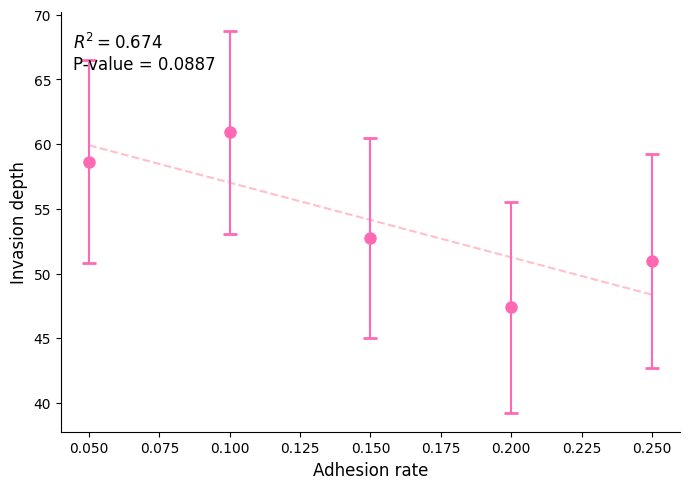

C:\Users\benbe\AppData\Local\Temp\ipykernel_16308\3358130948.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = est2.pvalues[1]


P-value: 0.05565191551361533


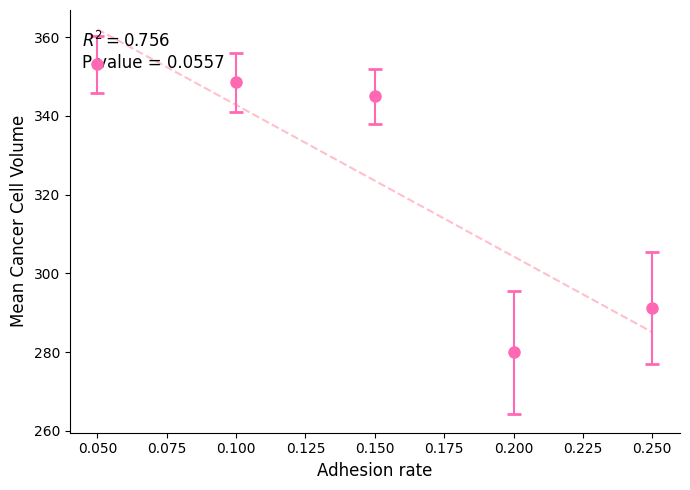

P-value: 0.005471830993466927


C:\Users\benbe\AppData\Local\Temp\ipykernel_16308\3358130948.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = est2.pvalues[1]


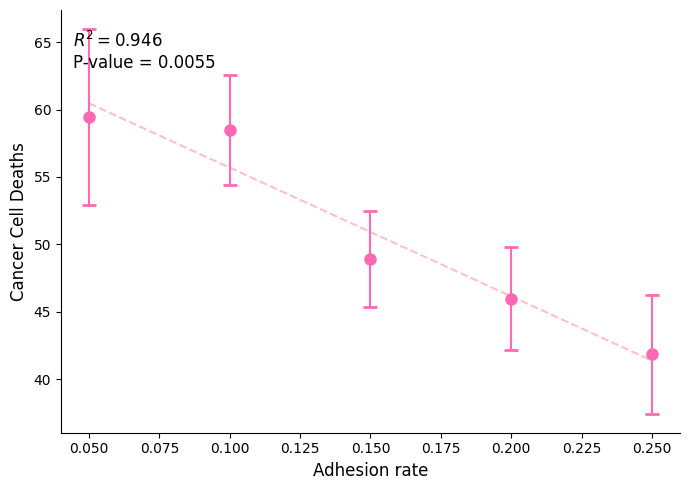

In [50]:
plot_results(df_div, "adhesion_rate", "invasion_depth", "Invasion depth")
plot_results(df_div, "adhesion_rate", "mean_vol_type1", "Mean Cancer Cell Volume")
plot_results(df_div, "adhesion_rate", "deaths_type1", "Cancer Cell Deaths")